In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 16})
save_path = './'

def save(name):
    plt.savefig(save_path+name+'.png', dpi=800, bbox_inches='tight')

# Root finding

In [2]:
def bisection(f, a, b, steps=50, tol=1e-10, local=True):
    '''Given a function f, a starting initial interval [a,b],
    perform the bisection method for at most 'steps'
    iterations or the truncation error |f(xn)|<tol.
    
    Set the flag local=False to only store the most recent
    iteration.'''

    # init
    i = 0
    cn = [a, b]

    if f(a) < 0 and f(b) >=0:
        inds = [0, 1]
    elif f(a) >= 0 and f(b) < 0:
        inds = [1, 0]
    else:
        raise ValueError('Check initial guesses')
        
    # main loop
    while i < steps and np.abs(f(cn[-1])) > tol:
        c = (cn[inds[0]] + cn[inds[1]])/2  # midpoint
        cn.append(c)
        
        negative = (f(c) < 0)        
        if local:
            if negative:
                inds[0] = i+2  # replace negative with c
            else:
                inds[1] = i+2  # replace positive with c
        else:
            if negative:
                cn = [c, cn[1]]
            else:
                cn = [cn[0], c]
            inds = [0, 1]
        i+=1
    if local:
        return np.array(cn)
    else:
        return cn[-1]

[1.         2.         1.5        1.25       1.375      1.4375
 1.40625    1.421875   1.4140625  1.41796875 1.41601562 1.41503906
 1.41455078 1.41430664 1.41418457 1.41424561 1.41421509 1.41419983
 1.41420746 1.41421127 1.41421318 1.41421413 1.41421366 1.41421342
 1.41421354 1.4142136  1.41421357 1.41421355 1.41421356 1.41421356
 1.41421356]
[-1.00000000e+00  2.00000000e+00  2.50000000e-01 -4.37500000e-01
 -1.09375000e-01  6.64062500e-02 -2.24609375e-02  2.17285156e-02
 -4.27246094e-04  1.06353760e-02  5.10025024e-03  2.33554840e-03
  9.53912735e-04  2.63273716e-04 -8.20010900e-05  9.06325877e-05
  4.31481749e-06 -3.88433691e-05 -1.72643340e-05 -6.47477282e-06
 -1.07998130e-06  1.61741718e-06  2.68717713e-07 -4.05631852e-07
 -6.84570836e-08  1.00130311e-07  1.58366129e-08 -2.63102355e-08
 -5.23681143e-09  5.29990096e-09  3.15445448e-11]


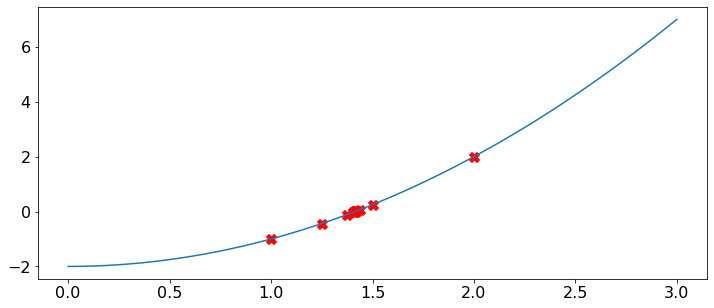

In [3]:
f = lambda x: x**2 - 2
fp = lambda x: 2*x

cn = bisection(f, 1, 2)
print(cn)
print(f(cn))
x = np.linspace(0, 3, 50)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(x, f(x))
ax.scatter(cn, f(cn), c='r', marker='X', s=100)
plt.show()

In [4]:
def newton(f, fp, x0, steps=50, tol=1e-10, local=True):
    '''Given a function f, its derivative fp and a starting
    guess x0, perform Newton's method for at most 'steps'
    iterations or the truncation error |f(xn)|<tol.
    
    Set the flag local=False to only store the most recent
    iteration.'''
    # init
    i = 0
    xn = [x0]
    
    # main loop
    while i < steps and np.abs(f(xn[-1])) > tol:
        xn.append(xn[-1] - f(xn[-1])/fp(xn[-1]))  # Newton step
        
        if not local:
            xn.pop(0)
        i+=1

    if local:
        return np.array(xn)
    else:
        return xn[-1]

[2.         1.5        1.41666667 1.41421569 1.41421356]


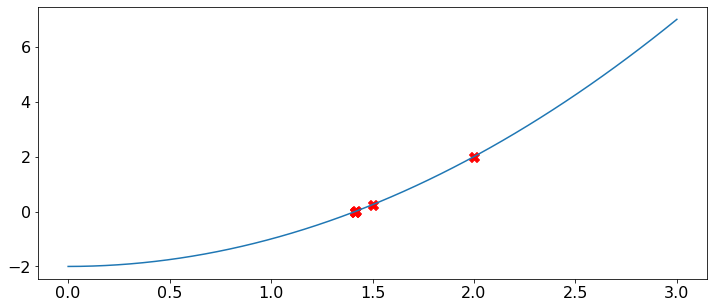

In [5]:
f = lambda x: x**2 - 2
fp = lambda x: 2*x

xn = newton(f, fp, 2)
print(xn)

x = np.linspace(0, 3, 50)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(x, f(x))
ax.scatter(xn, f(xn), c='r', marker='X', s=100)
plt.show()

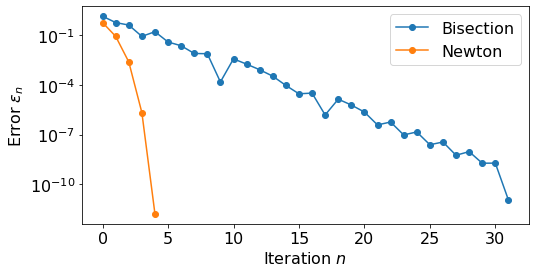

In [6]:
cn = bisection(f, 0, 2)
errB = np.abs(cn - np.sqrt(2))
xn = newton(f, fp, 2)
errN = xn - np.sqrt(2)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(errB, 'o-', label="Bisection")
ax.plot(errN, 'o-', label="Newton")
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Iteration $n$')
ax.set_ylabel(r'Error $\varepsilon_n$')
save('bisectionVsNewton')
plt.show()

# Diffusion solver

In [113]:
def diffusion_FE(phi_fn, k=1, dx=1, L=100, dt=0.01, T=50, snapshots=[]):
    '''Given initial condition phi_fn(np.array -> np.array), solve the
    diffusion equation using forward Eulerwith coef k on domain [0,L]
    with grid space dx. Simulate to time T with timestep dt. Save
    extra snapshots as a list of indices.'''
    assert dt <= dx**2/(2*k), "Unstable, check dt"
    
    # Time and space axis
    t_list = np.arange(0, T, dt, dtype=np.float64)
    x = np.arange(0, L, dx, dtype=np.float64)
    
    # IC
    phi = np.array(phi_fn(x), dtype=np.float64)
    
    phi_list = []
    ts = []
    
    n = len(x)
    dtdx = k*dt/dx**2
    
    # Matrix for FE
    M = (1-2*dtdx)*np.identity(n) + \
        dtdx*np.diag([1]*(n-1), 1) + \
        dtdx*np.diag([1]*(n-1), -1)
    
    # BC
    M[0,0], M[n-1,n-1] = 1, 1

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi)
            ts.append(t)
        phi = M@phi  # FE step

    phi_list.append(phi)
    ts.append(t)
    return x, ts, phi_list

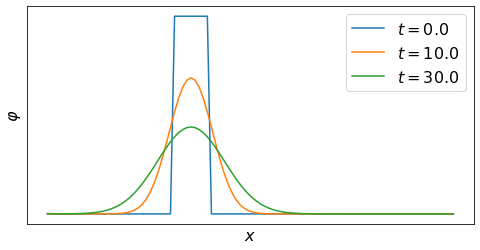

In [114]:
tophat = lambda x: (30<x) * (x<40)
x, t, phi_list = diffusion_FE(tophat, snapshots=[0, 1000, 3000])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for i, phi in enumerate(phi_list[:-1]):
    ax.plot(x, phi, label=f'$t = {t[i]}$')
    
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\varphi$')
ax.legend()

save('diffusionSpreading2')
plt.show()

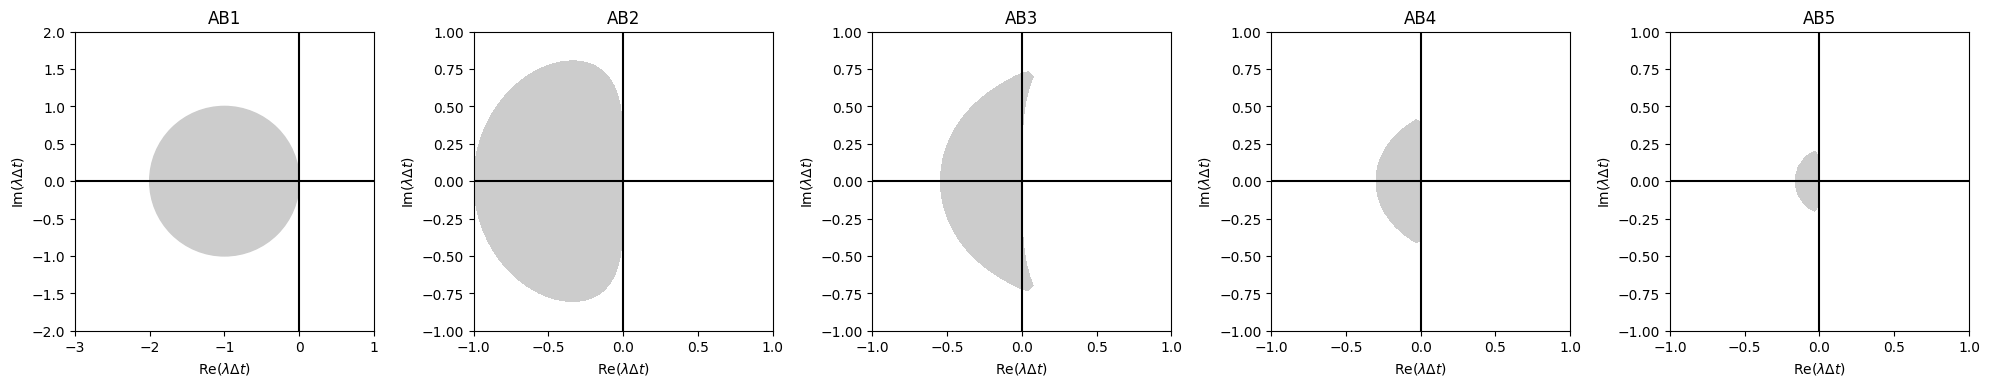

In [4]:
### Adapted from
# https://commons.wikimedia.org/wiki/File:Stability_region_for_BDF1.svg

plotWindow = {'realPart': [-2, 5], 'imagPart': [-3, 3]}

# Returns > 1 if argument is not in region of absolute stability
def AB2_stabilityFunction(dtLambda):
    stabPolyCoeffs = [1, -1 - 3/2*dtLambda,
                      1/2 * dtLambda]
    return max(abs(np.roots(stabPolyCoeffs)))

def AB3_stabilityFunction(dtLambda):
    stabPolyCoeffs = [1, -1 - 23/12*dtLambda,
                      16/12*dtLambda, -5/12*dtLambda]
    return max(abs(np.roots(stabPolyCoeffs)))

def AB4_stabilityFunction(dtLambda):
    stabPolyCoeffs = [1, -1 - 55/24*dtLambda,
                      59/24*dtLambda, -37/24*dtLambda, 9/24*dtLambda]
    return max(abs(np.roots(stabPolyCoeffs)))

def AB5_stabilityFunction(dtLambda):
    stabPolyCoeffs = [1, -1 - 1901/720*dtLambda,
                      2774/720*dtLambda, -2616/720*dtLambda,
                      1274/720*dtLambda, -251/720*dtLambda]
    return max(abs(np.roots(stabPolyCoeffs)))



# AB3
x = np.linspace(*plotWindow['realPart'], num=200)
y = np.linspace(*plotWindow['imagPart'], num=100) 
[X, Y] = np.meshgrid(x, y)

Z_AB2 = np.zeros(X.shape)
Z_AB3 = np.zeros(X.shape)
Z_AB4 = np.zeros(X.shape)
Z_AB5 = np.zeros(X.shape)


for m in range(X.shape[0]):
    for n in range(X.shape[1]):
        Z_AB2[m, n] = AB2_stabilityFunction(X[m, n] + 1j * Y[m, n])
        Z_AB3[m, n] = AB3_stabilityFunction(X[m, n] + 1j * Y[m, n])
        Z_AB4[m, n] = AB4_stabilityFunction(X[m, n] + 1j * Y[m, n])
        Z_AB5[m, n] = AB5_stabilityFunction(X[m, n] + 1j * Y[m, n])

fig, axs = plt.subplots(1, 5, figsize=(20, 12))
shading = '0.8'

for ax in axs.reshape(-1):
    ax.set_aspect('equal')
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_xlabel(r'Re($\lambda\Delta t$)')
    ax.set_ylabel(r'Im($\lambda\Delta t$)')

ax = axs[0]
ax.axis([-3, 1, -2, 2])
ax.set_title('AB1')
ax.add_patch(plt.Circle((-1, 0), 1, color=shading))


ax = axs[1]
ax.axis([-1, 1, -1, 1])
ax.set_title('AB2')
ax.contourf(X, Y, Z_AB2, [0, 1], colors=shading)


ax = axs[2]
ax.axis([-1, 1, -1, 1])
ax.set_title('AB3')
ax.contourf(X, Y, Z_AB3, [0, 1], colors=shading)

ax = axs[3]
ax.axis([-1, 1, -1, 1])
ax.set_title('AB4')
ax.contourf(X, Y, Z_AB4, [0, 1], colors=shading)

ax = axs[4]
ax.axis([-1, 1, -1, 1])
ax.set_title('AB5')
ax.contourf(X, Y, Z_AB5, [0, 1], colors=shading)


fig.tight_layout()
plt.savefig(save_path+'ABstab.png', dpi=800, bbox_inches='tight')
plt.show()